In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import pandas as pd
import matplotlib.animation as animation
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
from scipy.spatial.transform import Rotation as R
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import axes3d

In [2]:
import mne
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import mne.viz
import os
import os.path as op
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.datasets import fetch_fsaverage

In [3]:
import sys 
sys.path.append("../../2023_asm_tembedding/code/")
import cebra_v2 as cebra2

In [15]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.criterion)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

## Load Data

In [4]:
def dataset_creator(files, event, tmin=0, tmax=4, freq=500):

    """
    Take the data from every file and collect only those corresponding to GDF-left or GDF-right in the interest_data list
    Those events last for a number of data corresponding to segment_length

    parameters: files: string list corresponding to the data folders paths
                events: int list corresponding to the numbers representatives of the events of interest
                segment_length: int corresponding to the length of the data segment we will keep
    """
    MI = []
    rest = []
    tmin, tmax = tmin * freq, tmax * freq

    for file in files:
        data = mne.io.read_raw_edf(file, preload=True)
        raw_data = data.get_data()
        total_events, dict = mne.events_from_annotations(data)
        index_events = [dict[event[i]] for i in range(len(event))]  
        index = [i for i in range(total_events.shape[0]) if total_events[i, 2] in index_events]
        interest_events = total_events[index, 0]
        interest_events_label = total_events[index, 2]
        for i in range(interest_events.shape[0]):
            if interest_events_label[i] == index_events[0]:
                MI.append(raw_data[:, interest_events[i] + tmin:interest_events[i] + tmax])
            elif interest_events_label[i] == index_events[1]:
                rest.append(raw_data[:, interest_events[i] + tmin:interest_events[i] + tmax])

    return np.array(MI), np.array(rest)

In [6]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
input_fname1 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf"
input_fname2 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.09.24].edf"
input_fname3 =  "/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.18.26].edf"
#Read raw data files where each file contains a run
raws = read_raw_edf(input_fname1, preload=True)
#Combine all loaded runs
#raw_obj = concatenate_raws(raws)
raw_obj = raws

raw_data = raw_obj.get_data()
print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data)))

#Plot epochs & PSD
raw_obj.plot(duration=120, n_channels=15, scalings=dict(eeg=420e-6))
raw_obj.plot_psd(average=True)

Extracting EDF parameters from /network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf...
EDF file detected


OSError: [Errno 5] Input/output error: '/network/lustre/iss02/aramis/projects/cracknetworks/sub-14/ses-03/EEG/Train-[2022.05.05-15.00.03].edf'

In [ ]:
event = ['OVTK_GDF_Left', 'OVTK_GDF_Right']
input_fname_list = [input_fname1, input_fname2, input_fname3]
MI, rest = dataset_creator(input_fname_list, event, tmin=0, tmax=4, freq=500)

## Utilitaires

In [9]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

## Synthetic data

In [12]:
def create_session(dfc,state_vector,i):
    list_factor = np.linspace(1,1.01,dfc.shape[1])
    dfc[i,:] = np.array([list_factor[k] * state_vector for k in range(len(list_factor))])

def generate_dataset(dfc):
    list_factor = np.linspace(1,3,dfc.shape[1])
    for i in range(dfc.shape[0]):
        state_vector = np.random.normal(loc = 0, scale = 10, size = dfc.shape[2])
        dfc[i,:] = np.array([list_factor[k] * state_vector for k in range(len(list_factor))])

def generate_dataset2(dfc):
    return np.random.uniform(low = -10, high = 10, size = dfc.shape)

def generate_dataset3(dfc):
    for i in range(dfc.shape[0]):
        dfc[i,:] =  np.random.normal(loc = 5*i, scale = 1, size = (dfc.shape[1],dfc.shape[2]))


## Cebra

In [15]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 50

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        100
    ),
    nn.GELU(),
    nn.Linear(
        100,
        3
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [16]:
fc_train_vector = dfc
discrete = meta

In [17]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_vector) #,discrete = discrete)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 3000, time_delta = 2)

In [18]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [19]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 7.7429, Train accuracy 0.00%
Epoch 100
Train loss 7.1719, Train accuracy 0.00%
Epoch 200
Train loss 7.1756, Train accuracy 0.00%
Epoch 300
Train loss 7.1691, Train accuracy 0.00%


KeyboardInterrupt: 

(-1.0980946630239488,
 1.0986962527036668,
 -1.099107825756073,
 1.0936758160591125)

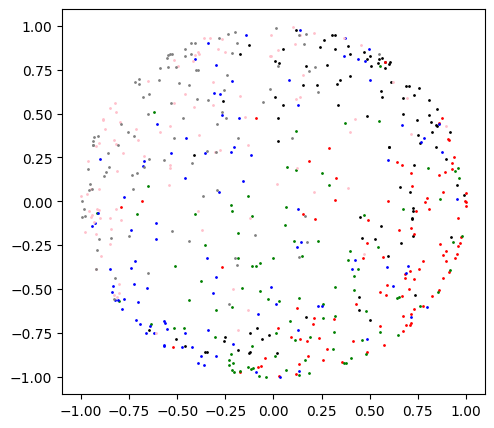

In [154]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red','green','blue','pink','grey']
for i in range(6):
    data = torch.from_numpy(dfc[i,:]).type(torch.float32)
    fc_emb = _compute_emissions_single(cebra_fc, data)
    ax1.scatter(fc_emb[:,2], fc_emb[:,0], c = colors[int(meta[i,0])], s=1)
#ax1.xticks() 
ax1.axis('on')

(-3.7011005531448546,
 28.980088508523682,
 -4.910444488123974,
 28.118389883589394)

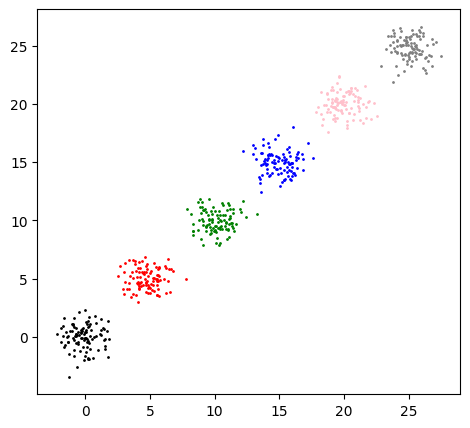

In [130]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red','green','blue','pink','grey']
for i in range(6):
    ax1.scatter(dfc[i,:,0], dfc[i,:,2], c = colors[int(meta[i,0])], s=1)
#ax1.xticks() 
ax1.axis('on')

In [47]:
fc_emb[:,0]

array([0.85154647, 0.84271604, 0.8054037 , 0.82855004, 0.8131946 ,
       0.7415217 , 0.7432062 , 0.8608511 , 0.8469128 , 0.64217544,
       0.8305512 , 0.82320195, 0.8491223 , 0.79578763, 0.6182777 ,
       0.8175461 , 0.8504333 , 0.80230516, 0.8471003 , 0.82638043,
       0.8019343 , 0.8563623 , 0.79516065, 0.8630579 , 0.8327116 ,
       0.82610893, 0.8330532 , 0.80367434, 0.81344324, 0.8560402 ,
       0.8664488 , 0.82001746, 0.8369263 , 0.8626054 , 0.83434916,
       0.7963342 , 0.8346572 , 0.84812737, 0.83650535, 0.86135453,
       0.835256  , 0.8555301 , 0.8232088 , 0.84169006, 0.83165634,
       0.7664996 , 0.67862934, 0.8362539 , 0.83639157, 0.83652824,
       0.7975961 , 0.92984766, 0.8660097 , 0.831456  , 0.8147686 ,
       0.8151435 , 0.8078452 , 0.83588475, 0.8001504 , 0.8334385 ,
       0.87690324, 0.8330698 , 0.8176767 , 0.8291991 , 0.8555954 ,
       0.80897653, 0.8212079 , 0.85831255, 0.823974  , 0.83280444,
       0.849166  , 0.8330515 , 0.84164   , 0.83329475, 0.83962